In [157]:
# Loading in the modules
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [65]:
# Buidling the UNET architecture 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer = HeNormal())(input)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer = HeNormal())(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   



def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)


    b1 = conv_block(p4, 1024) 

 
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4) 
    model = Model(inputs, outputs = outputs, name="U-Net")
    return model

In [69]:
# Loading in the images and masks
import os
map_dir = r'./CoralReef_Map'
mask_dir = r'./CoralReef_Mask'
map_sort = os.listdir(map_dir)
mask_sort = os.listdir(mask_dir)

In [75]:
def load_images(map_sort, mask_sort, map_dir, mask_dir):
    images, masks = [],[]
    slash = "\\"
    for img, msk in tqdm(zip(map_sort, mask_sort), total=len(map_sort), desc = 'Loading Images and Masks'):
        image_string = map_dir + slash + img
        image = cv2.imread(image_string, cv2.IMREAD_COLOR)
        mask_string = mask_dir + slash + msk
        mask = cv2.imread(mask_string, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256,256))
        mask = cv2.resize(mask, (256,256))
        images.append(image)
        masks.append(mask)

        del image, mask
    return images, masks
    

In [77]:
# Converting the images into tensors
I,M = load_images(map_sort, mask_sort, map_dir, mask_dir)

Loading Images and Masks: 100%|██████████████████████████████████████████████████████| 250/250 [00:02<00:00, 83.37it/s]


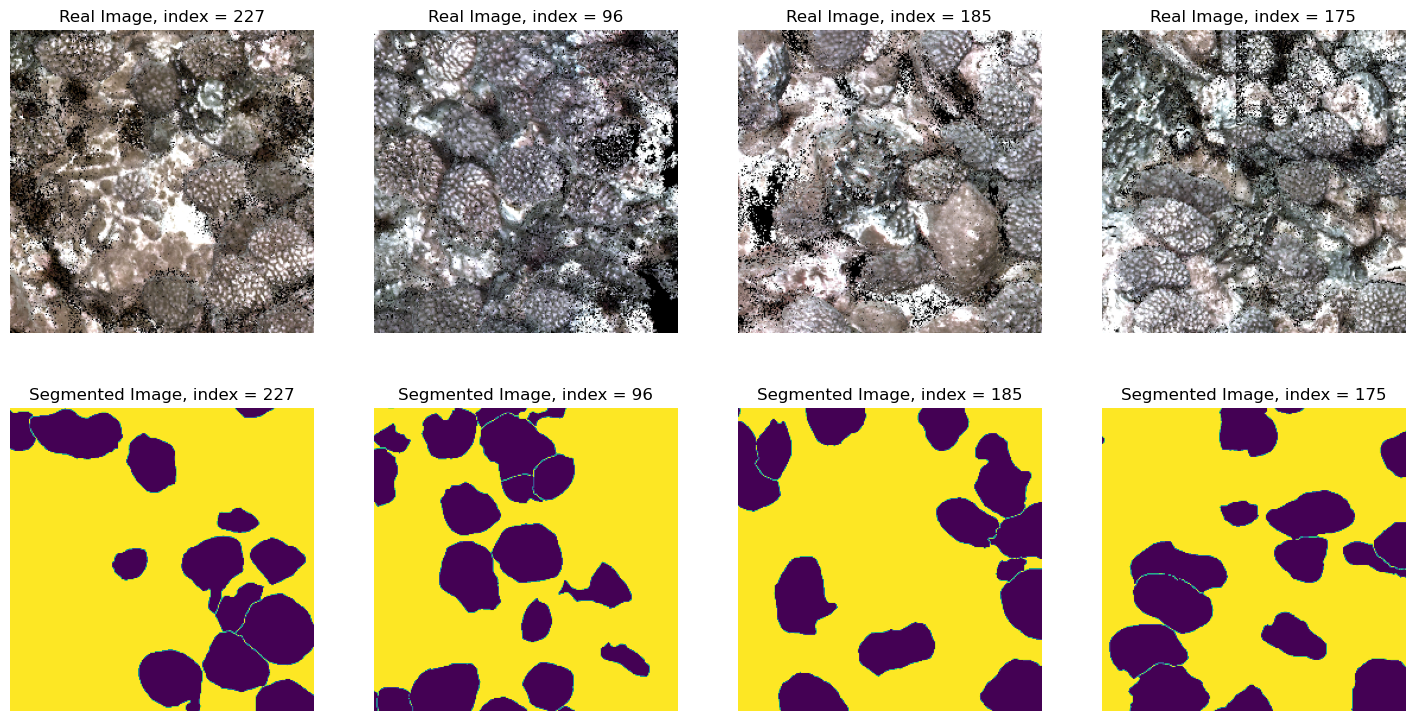

In [79]:
#Visualizing the images
import random
def plot_image_with_mask(image_list, mask_list, num_pairs = 4):
    plt.figure(figsize = (18,9))
    for i in range(num_pairs):
        idx = random.randint(0, len(image_list))
        img = image_list[idx]
        mask = mask_list[idx]
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Real Image, index = {idx}')
        plt.axis('off')
        plt.subplot(2, 4, i + num_pairs + 1)
        plt.imshow(mask)
        plt.title(f'Segmented Image, index = {idx}')
        plt.axis('off')
        del img, mask

plot_image_with_mask(I, M, num_pairs = 4)

In [89]:
# Changing the dimensions
I = np.array(I)
I = np.expand_dims(I,-1)
M = np.array(M)
M = np.expand_dims(M,-1)

In [143]:
# Splitting the images into training and testing set|
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(I, M, test_size = 0.25, random_state = 0)

In [145]:
X_test = np.squeeze(X_test)
X_train = np.squeeze(X_train)
y_train = np.squeeze(y_train, axis=-1)
y_test = np.squeeze(y_test, axis=-1)

In [147]:
# Getting the shape of the input image
IMG_HEIGHT = I.shape[1]
IMG_WIDTH = I.shape[2]
IMG_CHANNELS = I.shape[3]
input_shape = (IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(256, 256, 3)


In [149]:
# Building the initial model
model = build_unet(input_shape)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_38 (Conv2D)            │ (None, 256, 256, 64)      │           1,792 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_36        │ (None, 256, 256, 64)      │             256 │ conv2d_38[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_36 (Activation)    │ (None, 256, 256, 64)      │               0 │ batch_normalization_36[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_39 (Conv2D)            │ (None, 256, 256, 64)      │          36,928 │ activation_36[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_37        │ (None, 256, 256, 64)      │             256 │ conv2d_39[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_37 (Activation)    │ (None, 256, 256, 64)      │               0 │ batch_normalization_37[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 128, 128, 64)      │               0 │ activation_37[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_40 (Conv2D)            │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_38        │ (None, 128, 128, 128)     │             512 │ conv2d_40[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_38 (Activation)    │ (None, 128, 128, 128)     │               0 │ batch_normalization_38[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_41 (Conv2D)            │ (None, 128, 128, 128)     │         147,584 │ activation_38[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_39        │ (None, 128, 128, 128)     │             512 │ conv2d_41[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_39 (Activation)    │ (None, 128, 128, 128)     │               0 │ batch_normalization_39[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_9               │ (None, 64, 64, 128)       │               

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
# Augmenting the images to increase the testing and training sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed=24
img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')
mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                    preprocessing_function = lambda x: np.where(x>147, 1, 0).astype(x.dtype))

image_data_generator = ImageDataGenerator(**img_data_gen_args)
batch_size = 8
image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

x = next(image_generator)
y = next(mask_generator)
for i in range(0,1):
    image = x[i]
    mask = y[i]



# Model checkpoint

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_cr.h5', verbose = 1, save_best_only = True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='logs')]

steps_per_epoch = 3*(len(X_train))//batch_size
#Fittting the model
history = model.fit(my_generator, validation_data=validation_datagen, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=15, callbacks=callbacks)



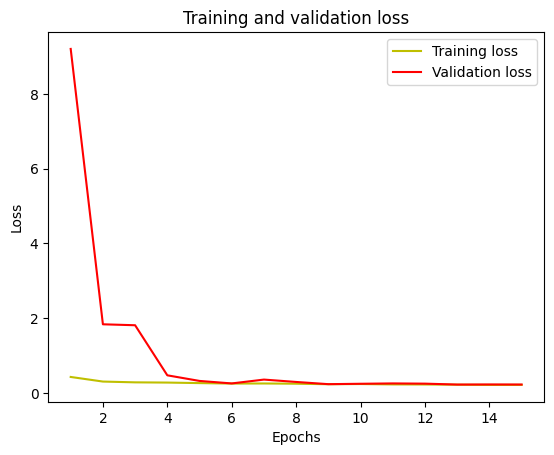

In [29]:
# Calculating the training and validation loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

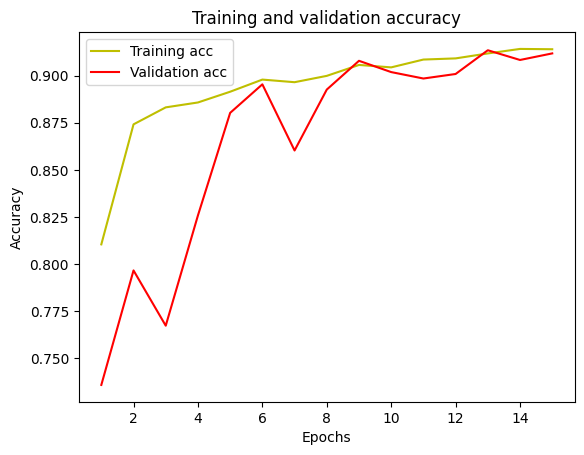

In [31]:
# Calculating the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
from tensorflow.keras.models import load_model
model.save(r".\\UNET_Model.h5")


Test img rgb info
(256, 256, 3)
255
test img input
(1, 256, 256, 3)
255
Prediction input
(None, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


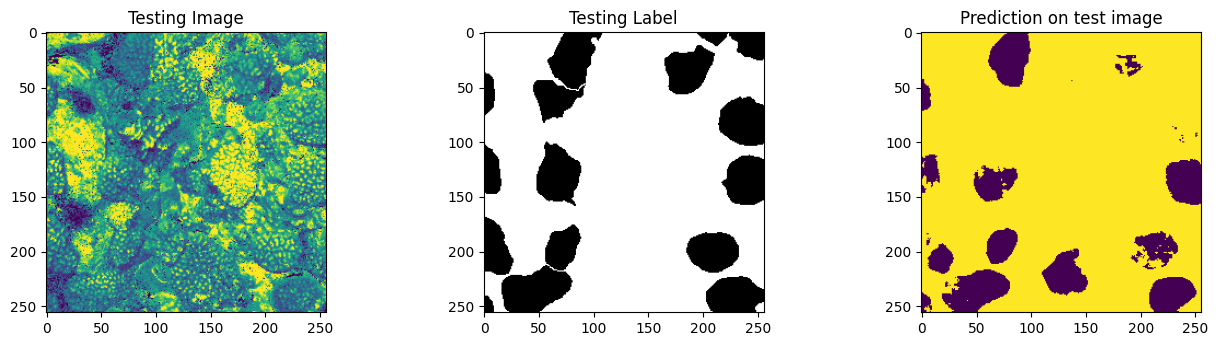

In [43]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

if test_img.ndim == 3:
    test_img = test_img[:, :, 0]


test_img_rgb = np.repeat(test_img[:, :, np.newaxis], 3, axis=2)  # Add RGB channels

test_img_input = np.expand_dims(test_img_rgb, axis=0)  # Normalize and batch

# Prediction
prediction = model.predict(test_img_input)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
ground_truth = np.where(ground_truth > 147, 1,0)
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
prediction= np.squeeze(prediction)
prediction_image = np.where(prediction > 0.65, 1,0)
plt.imshow(prediction_image)

plt.show()